## **PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle**

# [SF-DST] Booking reviews

In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(seed=123456)
np.set_printoptions(suppress=True, precision=2, linewidth=100)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 40

from scipy.stats import expon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce

import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import time
start_time = time.time()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Рабочая задача:   
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Описание признаков:

|Variable|Description|
|---|---|
|hotel_address|адрес отеля|
|review_date|дата, когда рецензент разместил соответствующий отзыв|
|average_score|средний балл отеля, рассчитанный на основе последнего комментария за последний год|
|hotel_name|название отеля|
|reviewer_nationality|страна рецензента|
|negative_review|отрицательный отзыв, который рецензент дал отелю|
|review_total_negative_word_counts|общее количество слов в отрицательном отзыв|
|positive_review|положительный отзыв, который рецензент дал отелю|
|review_total_positive_word_counts|общее количество слов в положительном отзыве|
|reviewer_score|оценка, которую рецензент поставил отелю на основе своего опыта|
|total_number_of_reviews_reviewer_has_given|количество отзывов, которые рецензенты дали в прошлом|
|total_number_of_reviews|общее количество действительных отзывов об отеле|
|tags|теги, которые рецензент дал отелю|
|days_since_review|количество дней между датой проверки и датой очистки|
|additional_number_of_scoring|есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки|
|lat|географическая широта отеля|
|lng|географическая долгота отеля|

In [2]:
df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')
df_submit = pd.read_csv('/kaggle/input/sf-booking/submission.csv')

df_train['is_train'] = 1
df_test['is_train'] = 0

In [3]:
def top_unique_values(df):
    col_names = ['Unique values', 'Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5', 'Top 6', 'Other']
    df_out = pd.DataFrame(columns=col_names)
    cols = df.columns
    for col in cols:
        top_vals = pd.DataFrame(df[col].value_counts(dropna=False, normalize=True)).iloc[0:6]
        lst = []
        lst.append(df[col].nunique())
        for r in top_vals.itertuples():
            i = str(r[0]) + ' (' + str(f'{r[1]:.1%}') + ')'
            lst.append(i)
        while len(lst) <= 6:
            lst.append('\u2013')
        remainder = 1 - top_vals[col].sum()
        if remainder != 0:
            lst.append(str(f'{remainder:.1%}'))
        else:
            lst.append('\u2013')
        row = (col, lst)
        df_out = pd.concat(
            [df_out, pd.DataFrame.from_dict(dict([row]), orient='index', columns=col_names)], 
            axis=0
        )
    return df_out

In [4]:
def iqr_outliers(df):
    vars = df.select_dtypes(np.number).columns
    df_out = df[vars].agg(
                lambda x: [
                    np.min(x), 
                    np.nanpercentile(x, 25), 
                    np.nanmean(x), 
                    np.nanmedian(x),
                    np.nanpercentile(x, 75), 
                    np.max(x)
                ])
    df_out.index = ['min', 'Q1', 'mean', 'median', 'Q3', 'max']
    df_out = df_out.transpose()
    
    lst = []
    for idx in df_out.index:
        row = (np.sum(df[idx] < df_out.loc[idx, 'Q1'] 
                      - 1.5 * (df_out.loc[idx, 'Q3'] - df_out.loc[idx, 'Q1'])),
               np.sum(df[idx] > df_out.loc[idx, 'Q3'] 
                      + 1.5 * (df_out.loc[idx, 'Q3'] - df_out.loc[idx, 'Q1']))
            )
        lst.append(row)
    outliers = pd.DataFrame(
        lst, 
        columns=['Values < 1.5IQR', 'Values > 1.5IQR'], 
        index=vars
    )
    df_out = (pd.concat([df_out, outliers], axis=1))
    return df_out

In [5]:
def hotel_addr(address):
    if address.split()[-2] == 'United':
        country = 'United ' + address.split()[-1]
        city = address.split()[-5]
    else: 
        country = address.split()[-1]
        city = address.split()[-2]
    return ', '.join([city, country])
    

# 1. EDA

Удаление полностью дублируемых записей

In [6]:
print(f'Duplicated rows: {df_train.duplicated().sum()}')
df_train = df_train.drop_duplicates()

Duplicated rows: 307


In [7]:
df = pd.concat([df_train, df_test], ignore_index=True)
train_mask = df['is_train'] == 1

pd.concat([df.head(2), df.tail(2)])

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,is_train
0,Stratton Street Mayfair Westminster ...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Stu...",531 day,51.51,-0.14,1
1,130 134 Southampton Row Camden Londo...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' St...",203 day,51.52,-0.12,1
515429,Corso Concordia 1 Milan City Center ...,159,12/26/2015,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel...,20,7,NaN,"[' Leisure trip ', ' Solo traveler '...",586 day,45.47,9.21,0
515430,202 rue de Rivoli 1st arr 75001 Pari...,297,12/23/2015,8.00,Saint James Albany Paris Hotel Spa,United Kingdom,rooms were very dated and old fashion,8,2868,No Positive,0,1,NaN,"[' Leisure trip ', ' Couple ', ' Sta...",589 day,48.86,2.33,0


In [8]:
# Remove whitespaces
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

В данных отсутствуют пропущенные значения, за исключением географических координат, информация о которых не будет использоваться в модели. Пропущенные значения в зависимой переменной reviewer_score относятся к той части данных, которые будет использованы для тестирования модели.

In [9]:
pd.DataFrame({
    'dtype': df.dtypes, 
    'obs': df.count(), 
    'nulls': df.isna().sum()
    })

,dtype,obs,nulls
hotel_address,object,515431,0
additional_number_of_scoring,int64,515431,0
review_date,object,515431,0
average_score,float64,515431,0
hotel_name,object,515431,0
reviewer_nationality,object,515431,0
negative_review,object,515431,0
review_total_negative_word_counts,int64,515431,0
total_number_of_reviews,int64,515431,0
positive_review,object,515431,0


In [10]:
df_top_values = top_unique_values(df)
df_top_values

,Unique values,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Other
hotel_address,1493,163 Marsh Wall Docklands Tower Hamle...,372 Strand Westminster Borough Londo...,Westminster Bridge Road Lambeth Lond...,Scarsdale Place Kensington Kensingto...,7 Pepys Street City of London London...,1 Inverness Terrace Westminster Boro...,95.5%
additional_number_of_scoring,480,2682 (0.9%),2288 (0.8%),2623 (0.8%),1831 (0.7%),1936 (0.6%),256 (0.6%),95.5%
review_date,731,8/2/2017 (0.5%),9/15/2016 (0.4%),4/5/2017 (0.4%),8/30/2016 (0.4%),2/16/2016 (0.4%),7/5/2016 (0.4%),97.5%
average_score,34,8.4 (8.0%),8.1 (7.4%),8.5 (7.4%),8.7 (7.3%),8.6 (7.2%),8.2 (6.8%),56.0%
hotel_name,1492,Britannia International Hotel Canary...,Strand Palace Hotel (0.8%),Park Plaza Westminster Bridge London...,Copthorne Tara Hotel London Kensingt...,DoubleTree by Hilton Hotel London To...,Grand Royale London Hyde Park (0.6%),95.5%
reviewer_nationality,227,United Kingdom (47.6%),United States of America (6.9%),Australia (4.2%),Ireland (2.9%),United Arab Emirates (2.0%),Saudi Arabia (1.7%),34.8%
negative_review,326566,No Negative (24.8%),Nothing (3.6%),nothing (0.5%),None (0.2%),N A (0.2%),(0.2%),70.5%
review_total_negative_word_counts,402,0 (24.8%),2 (4.8%),3 (3.5%),6 (3.4%),5 (3.3%),7 (3.1%),57.1%
total_number_of_reviews,1142,9086 (0.9%),9568 (0.8%),12158 (0.8%),7105 (0.7%),7491 (0.6%),6539 (0.6%),95.5%
positive_review,407552,No Positive (7.0%),Location (2.0%),Everything (0.6%),location (0.3%),Nothing (0.3%),Great location (0.3%),89.6%


In [11]:
df_iqr_outliers = iqr_outliers(df)
df_iqr_outliers

,min,Q1,mean,median,Q3,max,Values < 1.5IQR,Values > 1.5IQR
additional_number_of_scoring,1.00,169.00,498.28,342.00,660.00,"2,682.00",0,29579
average_score,5.20,8.10,8.40,8.40,8.80,9.80,9556,0
review_total_negative_word_counts,0.00,2.00,18.54,9.00,23.00,408.00,0,39137
total_number_of_reviews,43.00,"1,161.00","2,744.26","2,134.00","3,633.00","16,670.00",0,25826
review_total_positive_word_counts,0.00,5.00,17.78,11.00,22.00,395.00,0,36313
total_number_of_reviews_reviewer_has_given,1.00,1.00,7.17,3.00,8.00,355.00,0,47747
reviewer_score,2.50,7.50,8.40,8.80,9.60,10.00,11885,0
lat,41.33,48.21,49.44,51.50,51.52,52.40,59942,0
lng,-0.37,-0.14,2.82,-0.00,4.83,16.43,0,36259
is_train,0.00,0.00,0.75,1.00,1.00,1.00,0,0


Количество адресов отелей на один больше названий отелей.

In [12]:
(df[['hotel_name', 'hotel_address']]
    .drop_duplicates()
    .groupby('hotel_name')
    .count()
    .query('`hotel_address` > 1')
)

,hotel_address
hotel_name,
Hotel Regina,3


In [13]:
(df[['hotel_name', 'hotel_address']]
    .drop_duplicates()
    .query('`hotel_name` == "Hotel Regina"')
)

,hotel_name,hotel_address
479,Hotel Regina,Bergara 2 4 Eixample 08002 Barcelona...
1428,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090...
1566,Hotel Regina,Via Cesare Correnti 13 Milan City Ce...


In [14]:
(df[['hotel_name', 'hotel_address']]
    .drop_duplicates()
    .groupby('hotel_address')
    .count()
    .query('`hotel_name` > 1')
)

,hotel_name
hotel_address,
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,2


In [15]:
(df[['hotel_name', 'hotel_address']]
    .drop_duplicates()
    .query('`hotel_address` == "8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom"')
)

,hotel_name,hotel_address
451,The Grand at Trafalgar Square,8 Northumberland Avenue Westminster ...
868,Club Quarters Hotel Trafalgar Square,8 Northumberland Avenue Westminster ...


В датасете присутствует три отеля с одинаковым названием в разных странах, а также два отеля располагаются по одному адресу. Для создания уникального признака отеля к его названию будет добавлена информация о городе и стране. Отдельным признаком при построении модели будет использована информация о географическом расположении отеля.

In [16]:
df['hotel_city_country'] = df['hotel_address'].apply(hotel_addr)
df['hotel_name_full'] =  df['hotel_name'] + ' ' + df['hotel_city_country']

В данных присутствуют три переменных, которые, предположительно, являются расчетными. В первую очередь, переменная среднего бала отеля (average_score) в соответствии с описанием данных содержит информацию на фиксированную дату. Во-вторых, переменная общее количество отзывов (total_number_of_reviews) с учетом дополнительных оценок (additional_number_of_scoring) отражает количество отзывов, которые получил отель. К сожалению данные показатели не соответствует тем, что представлены в датасете. 

В реальной жизни, было бы целесообразно произвести расчет данных показателей во время формирования датасета. В условиях конкурса с уже разделенными данными, будут использоваться имеющиеся показатели. Предположительно, два последних из них будут иметь высокую положительную корреляцию друг с другом. Переменная average_score в данном случае будет являться прокси трансформацией переменной с названием отеля, которая могла бы быть получена с помощью метода Target Encoder из библиотеки кодирования категориальных признаков category_encoders.

In [17]:
(df[['hotel_name_full', 'average_score']]
    .drop_duplicates()
    .merge(
        df[['hotel_name_full', 'reviewer_score']]
        .groupby(by='hotel_name_full')
        .mean()
        .reset_index(),
        on='hotel_name_full',
        how='outer'
    )
    .rename(columns={'reviewer_score': 'calculated_average_score'})
).head(5)

,hotel_name_full,average_score,calculated_average_score
0,"The May Fair Hotel London, United Ki...",8.40,8.27
1,Mercure London Bloomsbury Hotel Lond...,8.30,8.43
2,Legend Saint Germain by Elegancia Pa...,8.90,9.01
3,Mercure Paris 19 Philharmonie La Vil...,7.50,6.86
4,Golden Tulip Amsterdam West Amsterda...,8.50,8.55


In [18]:
(df[['hotel_name_full', 'total_number_of_reviews']]
    .drop_duplicates()
    .merge(
        df[['hotel_name_full', 'reviewer_score', 'additional_number_of_scoring']]
        .groupby(by='hotel_name_full')
        .agg({'reviewer_score': 'count', 'additional_number_of_scoring': 'mean'})
        .reset_index(),
        on='hotel_name_full',
        how='outer'
    )
    .rename(columns={'reviewer_score': 'calculated_number_of_reviews'})
    .astype({'additional_number_of_scoring': 'int'})
).head(5)

,hotel_name_full,total_number_of_reviews,calculated_number_of_reviews,additional_number_of_scoring
0,"The May Fair Hotel London, United Ki...",1994,589,581
1,Mercure London Bloomsbury Hotel Lond...,1361,432,299
2,Legend Saint Germain by Elegancia Pa...,406,61,32
3,Mercure Paris 19 Philharmonie La Vil...,607,40,34
4,Golden Tulip Amsterdam West Amsterda...,7586,1263,914


Собранные в датасете отзывы были оставлены в течение двух лет - с 2015 по 2017 годы. От месяца к месяцу количество и средняя оценка отзывов варьируется, поэтому в качестве независимой переменной в модели будет применяться номер месяца для возможного отражения сезонности.

In [19]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date'].agg(['min', 'max']).to_frame()

,review_date
min,2015-08-04
max,2017-08-03


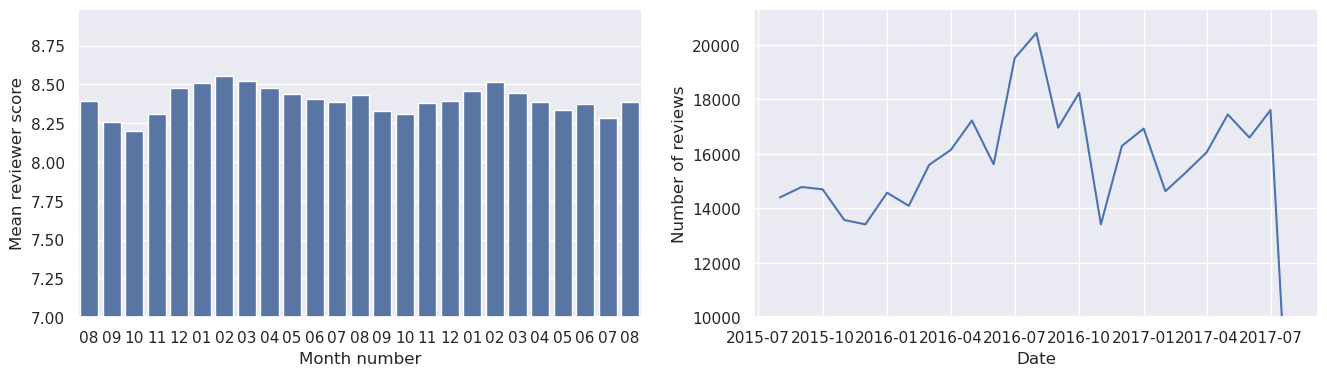

In [20]:
df_tmp = (
    df[['review_date', 'reviewer_score']]
    .set_index('review_date')
    .dropna()
    .groupby(pd.Grouper(freq='MS'))
    .agg(['count', 'mean'])
    .droplevel(0, axis=1)
    .reset_index()
)

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))

sns.barplot(data=df_tmp, x=df_tmp['review_date'], y=df_tmp['mean'], color='#4C72B0', ax=ax1)
sns.lineplot(data=df_tmp, x=df_tmp['review_date'], y=df_tmp['count'], ax=ax2)

ax1.set_xlabel('Month number')
ax1.set_xticklabels(labels=df_tmp['review_date'].dt.strftime('%m'))
ax1.set_ylabel('Mean reviewer score')
ax1.set_ylim(bottom=7)

ax2.set_xlabel('Date')
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y-%m"))
ax2.set_ylabel('Number of reviews')
ax2.set_ylim(bottom=10_000);

В переменной reviewer_nationality отражена информация о национальности рецензентов. В столбце присутствует 227 уникальных значений, т.е. практически все страны мира. На пять самых встречаемых национальностей приходится около 2/3 отзывов, оставшиеся отзывы оставлены рецензентами большего числа стран. При этом в целом для примерно половины национальностей присутствует 50 и менее отзывов. В случае использования признака в модели целесообразно снизить кардинальность данных путем группировки национальностей по географическим регионам.

In [21]:
(df['reviewer_nationality']
    .value_counts()
    .to_frame()
    .query('`reviewer_nationality` <= 50')
    .shape
)

(107, 1)

В отдельной переменной храниться информация о количестве дней, прошедших с даты, в которую был оставлен последний отзыв (3 августа 2017 года) и произведена выгрузка данных. Данные имеют строкой формат и потребуют дополнительной обработки.

In [22]:
np.datetime_as_string(
    df.loc[df['days_since_review'] == '0 days', 'review_date'].unique()[0], 
    unit='D'
)

'2017-08-03'

Общее количество отзывов, которые оставил рецензент, отражено в переменной total_number_of_reviews_reviewer_has_given. Как видно из графиков ниже значение количества отзывов имеет экспоненциальное распределение: большинство пользователей сервиса оставило всего несколько отзывов и, в тоже время, единицы пользователей имеют более пяти комментариев. В этой связи можно попробовать сегментировать пользователей в группы следующим образом:

|Категория|Значение признака (% от всех пользователей)|Кол-во отзывов|
|---|---|---|
|Категория 1|1.0|1|
|Категория 2|25.0|2-3|
|Категория 3|50.0|4-5|
|Категория 4|90.0|6-14|
|Категория 5|99.0|15-41|
|Категория 6|99.9|>42|

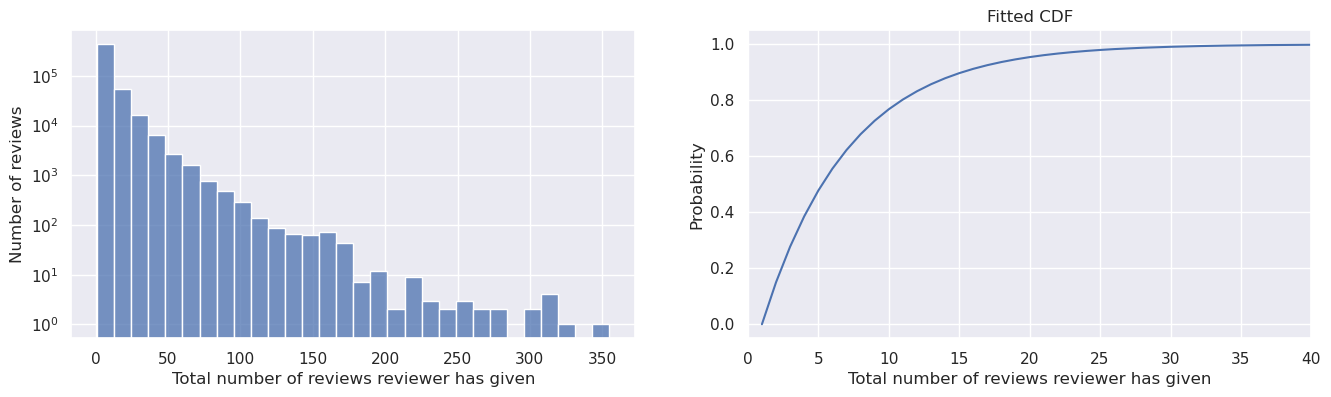

In [23]:
exp_params = expon.fit(df['total_number_of_reviews_reviewer_has_given'])
exp_cdf = expon.cdf(np.arange(1, 350, 1), exp_params[0], exp_params[1])

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x=df['total_number_of_reviews_reviewer_has_given'], bins=30, log_scale=(False, True), ax=ax1);
sns.lineplot(x=np.arange(1, 350, 1), y=exp_cdf, ax=ax2)

ax1.set_xlabel('Total number of reviews reviewer has given')
ax1.set_ylabel('Number of reviews')

ax2.set_title('Fitted CDF')
ax2.set_xlabel('Total number of reviews reviewer has given')
ax2.set_ylabel('Probability')
ax2.set_xlim(right=40, left=0);

В переменной tags в строковом виде хранятся тэги, выбранные рецензентами, которые имеют структуру списка. Минимальное количество тэгов, которое может быть выбрано, равно одному; максимальное - шести. Т.е. пользователь мог заполнить от одного до шести тэгов и, соответственно, длина списка не является фиксированной. Из топ-10 тэгов видно, что они содержат информацию о:
* типе визита (отдых или бизнес);
* количестве гостей (один, пара, семья);
* типе номера (стандартный, улучшенный);
* количество дней визита;
* тип устройства, с которого оставлен отзыв;
* и т.д.

Для целей прогнозирования оценки в отзыве наиболее подходящей выглядит информация о типе визита, так как для гостей, останавливающихся в отеле по разным причинам, важны различные характеристики, и, вероятно, этот признак будет целенаправленно влиять на вариацию в значениях зависимой переменной.

In [24]:
df_tags = (df['tags']
            .str.strip("[']")
            .str.replace(" ', '", ",")
            .str.split(',', expand=True)
        )
df_tags = df_tags.rename(
    columns={
        0: 'tag_1', 
        1: 'tag_2', 
        2: 'tag_3', 
        3: 'tag_4', 
        4: 'tag_5', 
        5: 'tag_6'}
    )
df_tags.head()

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6
0,Leisure trip,Couple,Studio Suite,Stayed 2 nights,Submitted from a mobile device,None
1,Business trip,Couple,Standard Double Room,Stayed 1 night,None,None
2,Leisure trip,Solo traveler,Modern Double Room Echo,Stayed 3 nights,Submitted from a mobile device,None
3,Leisure trip,Solo traveler,Standard Room with 1 Double Bed,Stayed 1 night,None,None
4,Business trip,Couple,Standard Double or Twin Room,Stayed 6 nights,None,None


In [25]:
(df_tags
    .isna()
    .sum()
    .to_frame()
    .transpose()
)

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6
0,0,6,91,5592,217015,514676


In [26]:
df_tags = df_tags.melt(value_vars=['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6'])
df_tags = df_tags.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_tags['value'].value_counts().iloc[0:10].to_frame()

,value
Leisure trip,417538
Submitted from a mobile device,307470
Couple,252128
Stayed 1 night,193568
Stayed 2 nights,133850
Solo traveler,108476
Stayed 3 nights,95761
Business trip,82884
Group,65361
Family with young children,60989


В переменных positive_review и negative_review хранится соответственно положительная и негативная части комментария рецензента об отеле, который представляет интерес с точки зрения определения тональности употребленных в нем выражений. Общая тональность комментария должна, в теории, иметь высокую предиктивную силу в отношении итоговой оценки. В качестве инструмента для оценки тональности текста будет использован VADER в составе пакета по работе с текстом NLTK.

Изучение наиболее встречаемых отзывов показывает, что обработка данных переменных потребует минимальных усилий с учетом того, какой механизм заложен в [VADER](https://github.com/cjhutto/vaderSentiment/blob/master/README.rst) для осуществления анализа текста. Главным образом, потребуется обнуление текста-плейсхолдера ("No Positive", "No Negative"), который устанавливается в качестве значение, когда рецензент не оставил полноценный комментарий. Кроме того, необходимо произвести замену фраз, которые имеют положительное значение, но написаны с использованием слов, которые либо подразумевают негативную или нейтральную коннотация и наоборот в английском языке. Например, словосочетание "вообще ничего" (nothing at all) в негативной части отзыва как ответ на вопрос "Что Вам не понравилось?".

In [27]:
(df.loc[train_mask, ['positive_review', 'reviewer_score']]
    .groupby('positive_review')
    .agg(['count', 'mean'])
    .droplevel(level=0, axis=1)
    .rename(columns={'count': 'reviews', 'mean': 'average_score'})
    .sort_values(by='reviews', ascending=False)
    .iloc[0:25, :]
    .style
    .format(precision=1)
    .background_gradient(subset=['average_score'], vmin=3, vmax=10, cmap='Greens')
)

,reviews,average_score
positive_review,,
No Positive,26863,6.9
Location,7487,6.9
Everything,2146,9.7
location,1293,6.8
Nothing,1099,3.6
Great location,1087,8.0
The location,980,6.5
Good location,903,6.7
Breakfast,493,7.1


In [28]:
(df.loc[train_mask, ['negative_review', 'reviewer_score']]
    .groupby('negative_review')
    .agg(['count', 'mean'])
    .droplevel(level=0, axis=1)
    .rename(columns={'count': 'reviews', 'mean': 'average_score'})
    .sort_values(by='reviews', ascending=False)
    .iloc[0:25, :]
    .style
    .format(precision=1)
    .background_gradient(subset=['average_score'], vmin=3, vmax=10, cmap='Reds')
)

,reviews,average_score
negative_review,,
No Negative,95833,9.3
Nothing,13885,9.6
nothing,1877,9.5
None,871,9.5
N A,818,9.6
,606,9.3
Nothing really,434,9.3
N a,391,9.5
All good,366,9.4


Сопутствующими переменными являются review_total_positive_word_counts и review_total_negative_word_counts, в которых подсчитано количество слов в каждой из частей. В соответствии с таблицей с описательной статистикой подавляющая часть комментариев содержит от пяти до 20 слов, но есть небольшая группа пользователей, которая оставила отзывы, содержащие до 400 слов. С точки зрения взаимосвязи между количеством слов в комментарии и выставленной оценкой наблюдается следующая ситуация:
* для положительной части отзыва: при преодолении невысокого порога в пару слов, средняя оценка отеля повышается. При достижении длины в 50 слов средняя оценка стабилизируется и сильно не изменяется пока длина комментария не превысит более 200 слов. Далее следуют редкие, но очень длинные комментарии, которые, смотря на скачкообразное изменение среднего бала, были написаны чрезвычайно мотивированными рецензентами, под положительным либо отрицательным впечатлениям от завершившейся поездки.
* для отрицательной части отзыва: начиная от самых коротких отзывов до больших комментариев, длиной до 200 слов, средняя оценка понижается. Т.е. чем более детально описаны отрицательные аспекты путешествия, тем ниже итоговая оценка отеля. Примерно на том же уровне в 200 слов и длиннее, средняя оценка продолжает снижаться, но крайне скачкообразно. По всей видимости, наблюдается повышенная экспрессивности о деталях пребывания в отеле. 

Помимо этого, потенциально значимым может быть расчетная переменная -- разница между длиной положительных и отрицательных отзывов. В целом, однако, такая переменная отражает вышеописанные особенности поведения.

Так как, планируется произвести небольшое количество замен в текстах отзывов и в текущем состоянии длина одного и того же комментария может иметь несколько значений, на этапе создания признаков значение данных переменных будут пересчитаны.

In [29]:
df_tmp_pos = df[['review_total_positive_word_counts', 'reviewer_score']].copy()
df_tmp_pos['polarity'] = 'Positive'
df_tmp_pos = df_tmp_pos.rename(columns={'review_total_positive_word_counts': 'word_count'})

df_tmp_neg = df[['review_total_negative_word_counts', 'reviewer_score']].copy()
df_tmp_neg['polarity'] = 'Negative'
df_tmp_neg = df_tmp_neg.rename(columns={'review_total_negative_word_counts': 'word_count'})

df_tmp = pd.concat([df_tmp_pos, df_tmp_neg], axis=0, ignore_index=True)
df_tmp['category'] = pd.cut(df_tmp['word_count'], np.histogram_bin_edges(df_tmp['word_count'], 50), right=False)

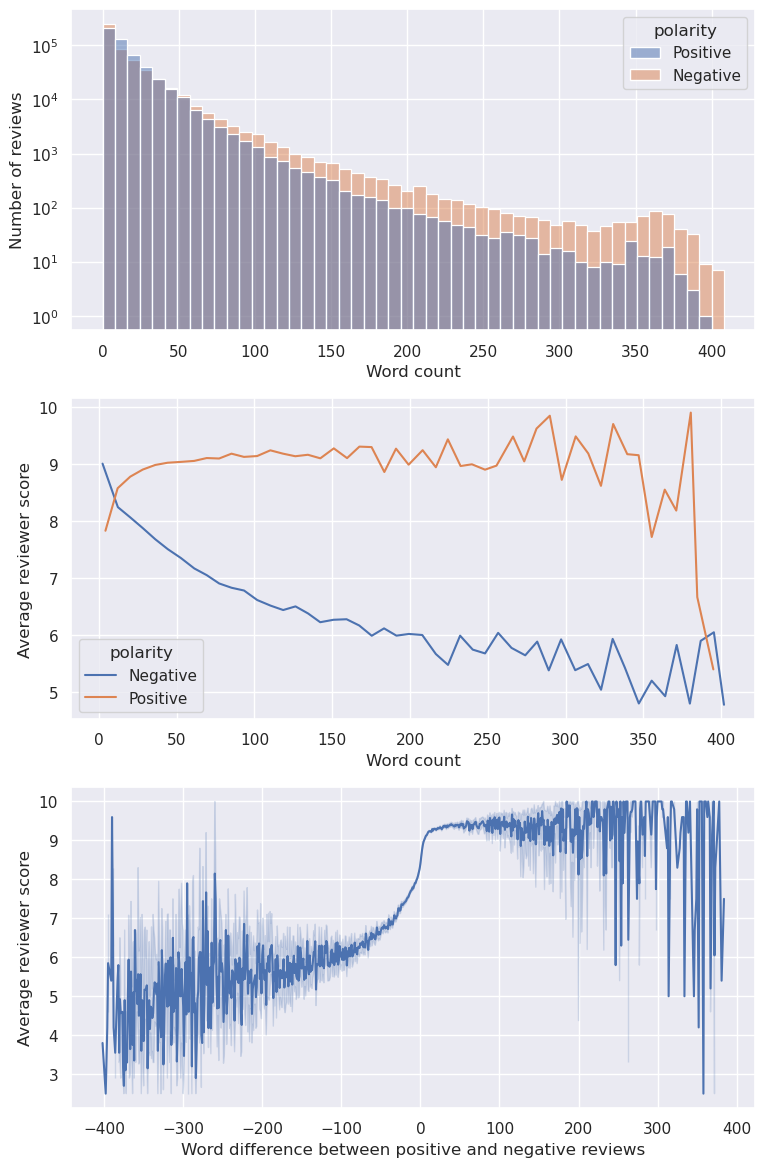

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig.tight_layout(pad=2)

sns.histplot(data=df_tmp, x='word_count', hue='polarity', log_scale=(False, True), bins=50, ax=ax1)
ax1.set_xlabel('Word count')
ax1.set_ylabel('Number of reviews')

df_tmp = df_tmp.groupby(by=['polarity', 'category']).mean().reset_index()

sns.lineplot(data=df_tmp, x='word_count', y='reviewer_score', hue='polarity', ax=ax2)
ax2.set_xlabel('Word count')
ax2.set_ylabel('Average reviewer score')

df_tmp = df[['review_total_positive_word_counts', 'review_total_negative_word_counts', 'reviewer_score' ]].copy()
df_tmp['word_diff'] = df_tmp['review_total_positive_word_counts'] - df_tmp['review_total_negative_word_counts']

sns.lineplot(data=df_tmp, x='word_diff', y='reviewer_score', errorbar=('ci', 95), ax=ax3)
ax3.set_xlabel('Word difference between positive and negative reviews')
ax3.set_ylabel('Average reviewer score');

In [31]:
(df.query('`positive_review` in ["Location was great", "Good breakfast"]')
    .loc[:, ['positive_review', 'review_total_positive_word_counts']]
    .groupby('positive_review')
    .agg(['min', 'max'])
)

review_total_positive_word_counts    
                                                 min max
positive_review                                         
Good breakfast                                     3   4
Location was great                                 4   5

In [32]:
(df.query('`negative_review` in ["All good", "Everything was perfect"]')
    .loc[:, ['negative_review', 'review_total_negative_word_counts']]
    .groupby('negative_review')
    .agg(['min', 'max'])
)

review_total_negative_word_counts    
                                                     min max
negative_review                                             
All good                                               3   4
Everything was perfect                                 4   5

Так как в датасете включены отзывы об отелях высшей категории, в основном выставляемые пользователями оценки находятся в высоком диапазоне (медиана = 8.8). В данных присутствует около 11 тыс. отзывов, выходящих за порог $\pm1.5$ межквартильного размаха с каждой стороны распределения, что составляет около 3% от записей. С учетом того, что зависимая переменная является субъективной оценкой пользователя, значения, которая она принимает может варьироваться в определенном создателями сервиса диапазоне и должна быть валидной для целей построения модели. В этой связи указанные выбросы не планируется исключать из тренировочного датасета.

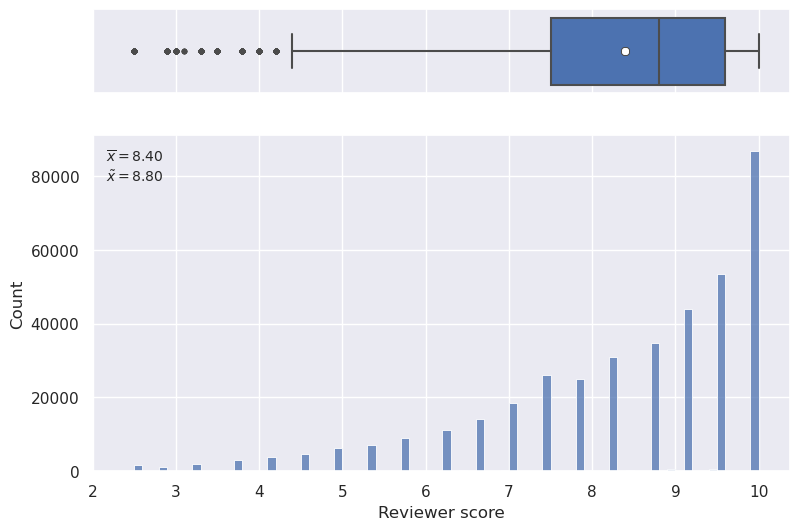

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={"height_ratios": (.2, .8)})
sns.boxplot(x=df['reviewer_score'].dropna(), 
            saturation=0.1, 
            showmeans=True, 
            width=0.8, 
            fliersize=6,
            boxprops={'facecolor': 'C0', 'edgecolor': '#4C4D4E', 'linewidth': 1.5},
            flierprops={"marker": "."},
            meanprops={'marker':'8', 'markerfacecolor':'w', 'markeredgecolor':'#4C4D4E', 'markeredgewidth':0.75},
            ax=ax1
        )
sns.histplot(x=df['reviewer_score'].dropna(), binwidth=0.1, ax=ax2)

ax1.set_xlabel(None)
ax1.set_xticks(np.arange(2,11,1), labels=[])
ax2.set_xlabel('Reviewer score')
ax2.set_ylabel('Count')
ax2.set_xticks(np.arange(2,11,1))

ax2.text(0.02, 0.96, r'$\overline{x}=$' 
         + f'{df_iqr_outliers.loc["reviewer_score", "mean"]:.2f}', size=10, horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.02, 0.90, r'$\tilde{x}=$' + f'{df_iqr_outliers.loc["reviewer_score", "median"]:.2f}', size=10, horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes);

# 2. Feature engineering

2.1 Кодирование уникального названия отеля с помощью OrdinalEncoder.

In [34]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(df['hotel_name_full'])
df['hotel_name_num'] = encoded

2.2 Кодирование географического расположения с помощью OneHotEncoder

In [35]:
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df['hotel_city_country'])
df = pd.concat([df, encoded], axis=1)
# pd.DataFrame(encoder.category_mapping[0]['mapping'], columns=['label']) doesn't work in ce 2.6.1
pd.DataFrame(pd.Series(encoder.get_feature_names_out(), df['hotel_city_country'].unique()), columns=['label'])

,label
"London, United Kingdom",hotel_city_country_1
"Paris, France",hotel_city_country_2
"Amsterdam, Netherlands",hotel_city_country_3
"Milan, Italy",hotel_city_country_4
"Vienna, Austria",hotel_city_country_5
"Barcelona, Spain",hotel_city_country_6


2.3 Извлечение номера месяца из даты

In [36]:
df['review_month'] = df['review_date'].dt.month

2.4 Обработка признака национальности рецензента:
* Группировка стран по регионам. Используется [методология UN](https://unstats.un.org/unsd/methodology/m49/) по кодированию стран и регионов для целей статистических наблюдений, которая разделяет мир на 17 подрегионов.
* Кодирование подрегиона с помощью OrdinalEncoder

In [37]:
regions = pd.read_html('https://unstats.un.org/unsd/methodology/m49/overview/')
regions = regions[0]
pd.concat([regions.head(2), regions.tail(2)])

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.00,Africa,15.00,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.00,Africa,15.00,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
247,1,World,9.00,Oceania,61.00,Polynesia,NaN,NaN,Tuvalu,798,TV,TUV,x,NaN,x
248,1,World,9.00,Oceania,61.00,Polynesia,NaN,NaN,Wallis and Futuna Islands,876,WF,WLF,NaN,NaN,NaN


In [38]:
regions = (
    regions.reindex(columns=['Sub-region Name', 'Country or Area'])
            .rename(columns={'Sub-region Name': 'subregion', 'Country or Area': 'country'})
        )

# Countries that need to be manually matched
pd.merge(
    pd.DataFrame(df['reviewer_nationality'].unique(), columns=['country']),
    regions,
    how='left',
    on='country'
).query('`subregion`.isna()')['country'].to_numpy()

array(['United Kingdom', 'Hong Kong', 'Netherlands', 'Iran', 'Turkey', '', 'Czech Republic',
       'South Korea', 'Vietnam', 'Russia', 'Brunei', 'Venezuela', 'Taiwan', 'Macedonia', 'Kosovo',
       'Abkhazia Georgia', 'Syria', 'Moldova', 'Bolivia', 'Tanzania', 'Macau', 'Ivory Coast',
       'Cura ao', 'U S Virgin Islands', 'Antarctica', 'Palestinian Territory',
       'Falkland Islands Malvinas', 'Turks Caicos Islands', 'Laos', 'Crimea', 'St Maarten',
       'Antigua Barbuda', 'St Pierre and Miquelon', 'Cocos K I', 'Wallis and Futuna', 'Swaziland',
       'Saint Martin', 'Saint Vincent Grenadines', 'Reunion', 'Bonaire St Eustatius and Saba',
       'East Timor', 'Svalbard Jan Mayen', 'Saint Barts', 'Central Africa Republic',
       'Vatican City', 'Cape Verde'], dtype=object)

In [39]:
# Use pre-made comparison table to save notebook space
regions = pd.read_csv('/kaggle/input/country-regions-table/regions.csv', sep=';')

pd.merge(
    pd.DataFrame(df['reviewer_nationality'].unique(), columns=['country']),
    regions,
    how='left',
    on='country'
).query('`subregion`.isna()')

,country,subregion
50,,NaN


In [40]:
# Merge two tables and fill blanks with the most frequent value
df = df.merge(regions, how='left', left_on='reviewer_nationality', right_on='country')
df['subregion'].value_counts(dropna=False).to_frame()

,subregion
Northern Europe,274245
Western Asia,47452
Northern America,43382
Western Europe,42713
Australia and New Zealand,24903
Southern Europe,22558
Eastern Europe,19456
Eastern Asia,9834
South-eastern Asia,9821
Sub-Saharan Africa,6059


In [41]:
df['subregion'] = df['subregion'].fillna(df['subregion'].value_counts(dropna=False).index[0])

encoder = ce.OrdinalEncoder(return_df=False)
encoded = encoder.fit_transform(df['subregion'])
df['subregion_cat'] = encoded

2.5 Извлечение информации о количестве дней, которые прошли с момента сбора данных

In [42]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

2.6 Преобразование переменной с общим количеством отзывов, которые оставил рецензент

In [43]:
def reviewer_activity(x):
    if x == 1:
        return 1
    elif (2 <= x <= 3):
        return 25
    elif (4 <= x <= 5):
        return 50
    elif (6 <= x <= 14):
        return 90
    elif (15 <= x <= 41):
        return 99
    else:
        return 99.9

In [44]:
df['reviewer_activity'] = df['total_number_of_reviews_reviewer_has_given'].apply(reviewer_activity)
df['reviewer_activity'].value_counts().to_frame()

,reviewer_activity
1.00,154561
90.00,116091
25.00,113854
50.00,62622
99.00,58735
99.90,9568


2.7 Извлечение признака типа путешествия из переменной тэгов и его кодирование

In [45]:
def is_leisure_trip(df_row):
    if 'Leisure trip' in df_row['tags']:
        return 1
    elif 'Business trip' in df_row['tags']:
        return 0
    else:
        return 100

In [46]:
df['is_leisure_trip'] = df.apply(is_leisure_trip, axis=1)
df['is_leisure_trip'].value_counts().to_frame()

,is_leisure_trip
1,417538
0,82884
100,15009


In [47]:
# Fill missing values (is_leisure_trip=100) randomly based on original data percentages
leisure_share = np.sum(df.loc[train_mask, 'is_leisure_trip'] == 1)
business_share = np.sum(df.loc[train_mask, 'is_leisure_trip'] == 0)
total_share = leisure_share + business_share
leisure_share /= total_share

In [48]:
def trip_type_fillna(trip):
    if trip == 100:
        rand_num = rng.uniform()
        if rand_num <= leisure_share:
            return 1
        else:
            return 0
    else:
        return trip

In [49]:
df['is_leisure_trip'] = df['is_leisure_trip'].apply(trip_type_fillna)
df['is_leisure_trip'].value_counts().to_frame()

,is_leisure_trip
1,430027
0,85404


Большинство отзывов было оставлено рецензентами, отдыхающими в отеле. При этом средний балл, выставленный данными рецензентами, выше оценок, которые были даны людьми, останавливающимися в отеле во время деловых поездок.

In [50]:
(df[['is_leisure_trip', 'reviewer_score']]
    .groupby('is_leisure_trip')
    .agg(['count', 'mean'])
)

reviewer_score     
                         count mean
is_leisure_trip                    
0                        63820 7.98
1                       322676 8.48

2.8 Обработка комментариев пользователей и проведение анализа тональности текста

In [51]:
replace_dict = {
    'positive_review': {
        'No Positive': '',
        'Everything': 'Everything is good',
        'everything': 'Everything is good',
        'Nothing': 'Everything is bad',
        'nothing': 'Everything is bad'
    },
    'negative_review': {
        'No Negative': '',
        'Nothing': 'Everything is good',
        'nothing': 'Everything is good',
        'None': 'Everything is good',
        'none': 'Everything is good',
        'N A': 'Everything is good',
        'N a': 'Everything is good',
        'n a': 'Everything is good',
        'Nil': 'Everything is good',
        'Nothing really': 'Everything is good',
        'Nothing at all': 'Everything is good',
        'No complaints': 'Everything is good',
        'Absolutely nothing': 'Everything is good',
        'Everything': 'Everything is bad',
    }
}
df = df.replace(replace_dict)
df['review_combined'] = df['positive_review'] + ' ' + df['negative_review']

In [52]:
sent_analyzer = SentimentIntensityAnalyzer()

def vader_polarity(review):
    sia_scores = sent_analyzer.polarity_scores(review)
    return pd.Series({
        'nltk_neg': sia_scores['neg'],
        'nltk_neu': sia_scores['neu'],
        'nltk_pos': sia_scores['pos'],
        'nltk_compound': sia_scores['compound']
    })

sia_scores = df['review_combined'].apply(vader_polarity)
df = pd.concat([df, sia_scores], axis=1)

2.9 Пересчет количества слов в положительной и негативной части комментария рецензента

In [53]:
df['pos_review_word_count'] = df['positive_review'].apply(lambda x: len(x.split()))
df['neg_review_word_count'] = df['negative_review'].apply(lambda x: len(x.split()))

# 3. Feature selection

In [54]:
df_model = df.copy()

Перечень всех признаков на текущий момент

In [55]:
pd.DataFrame({
    'dtype': df_model.dtypes, 
    'obs': df_model.count(), 
    'nulls': df_model.isna().sum()
    }).reset_index().sort_values(by=['dtype', 'index'])

,index,dtype,obs,nulls
1,additional_number_of_scoring,int64,515431,0
14,days_since_review,int64,515431,0
21,hotel_city_country_1,int64,515431,0
22,hotel_city_country_2,int64,515431,0
23,hotel_city_country_3,int64,515431,0
24,hotel_city_country_4,int64,515431,0
25,hotel_city_country_5,int64,515431,0
26,hotel_city_country_6,int64,515431,0
20,hotel_name_num,int64,515431,0
32,is_leisure_trip,int64,515431,0


Удаление строковых переменных, дат и признаков, которые больше не потребуются в работе

In [56]:
# Remove object and datetime columns
print(df_model.select_dtypes(['O', 'M']).columns.tolist())
df_model = df_model.drop(columns=df_model.select_dtypes(['O', 'M']).columns)

['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'hotel_city_country', 'hotel_name_full', 'country', 'subregion', 'review_combined']


In [57]:
# Remove obsolete columns
df_model = df_model.drop(columns=['lat', 'lng', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
                                  'total_number_of_reviews_reviewer_has_given'])

Очищенный датасет с переменными, готовыми к использованию в модели

In [58]:
pd.DataFrame({
    'dtype': df_model.dtypes, 
    'obs': df_model.count(), 
    'nulls': df_model.isna().sum()
    })

,dtype,obs,nulls
additional_number_of_scoring,int64,515431,0
average_score,float64,515431,0
total_number_of_reviews,int64,515431,0
reviewer_score,float64,386496,128935
days_since_review,int64,515431,0
is_train,int64,515431,0
hotel_name_num,int64,515431,0
hotel_city_country_1,int64,515431,0
hotel_city_country_2,int64,515431,0
hotel_city_country_3,int64,515431,0


Разделение датасета на зависимую и независимые переменные и группировка признаков на числовые и категориальные

In [59]:
X_train = df_model[train_mask].drop(columns=['is_train', 'reviewer_score'])
y_train = df.loc[train_mask, 'reviewer_score']

numeric_vars = ['additional_number_of_scoring', 'average_score', 'total_number_of_reviews', 
                'days_since_review', 'nltk_neg', 'nltk_neu', 'nltk_pos', 'nltk_compound', 
                'pos_review_word_count', 'neg_review_word_count']
categorical_vars = ['hotel_name_num', 'review_month', 'subregion_cat', 'reviewer_activity', 
                    'is_leisure_trip', 'hotel_city_country_1', 'hotel_city_country_2', 
                    'hotel_city_country_3', 'hotel_city_country_4', 'hotel_city_country_5', 
                    'hotel_city_country_6']

Одномерная регрессия для определения значимости признаков

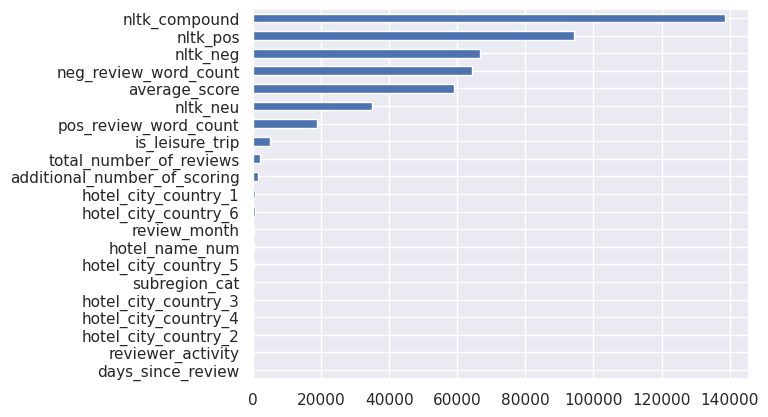

In [60]:
f_regression_vals = pd.Series(f_regression(X_train, y_train)[0], index=X_train.columns).sort_values()
f_regression_vals.plot(kind='barh');

Корреляционная матрица для числовых и категориальных признаков

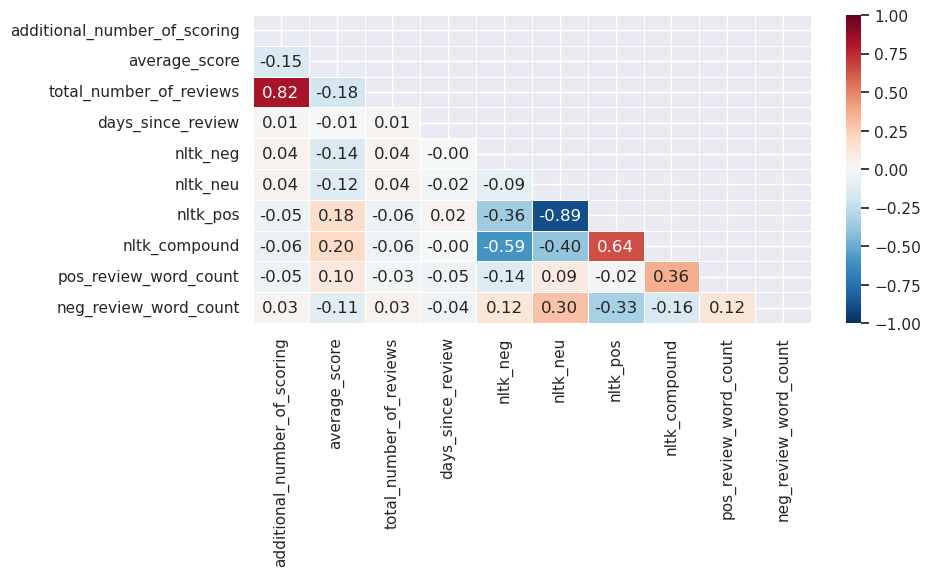

In [61]:
corr_matrix = np.tril(X_train[numeric_vars].corr(method='pearson'))
corr_matrix[corr_matrix == 0] = np.NaN
np.fill_diagonal(corr_matrix, np.NaN)

fig, ax = plt.subplots(figsize=(9, 4))
sns.heatmap(
    data=corr_matrix, 
    vmin=-1, 
    vmax=1,
    fmt='.2f', 
    cmap="RdBu_r", 
    linewidths=0.5, 
    annot=True, 
    xticklabels=X_train[numeric_vars].columns,
    yticklabels=X_train[numeric_vars].columns,
    robust=True,
    ax=ax);

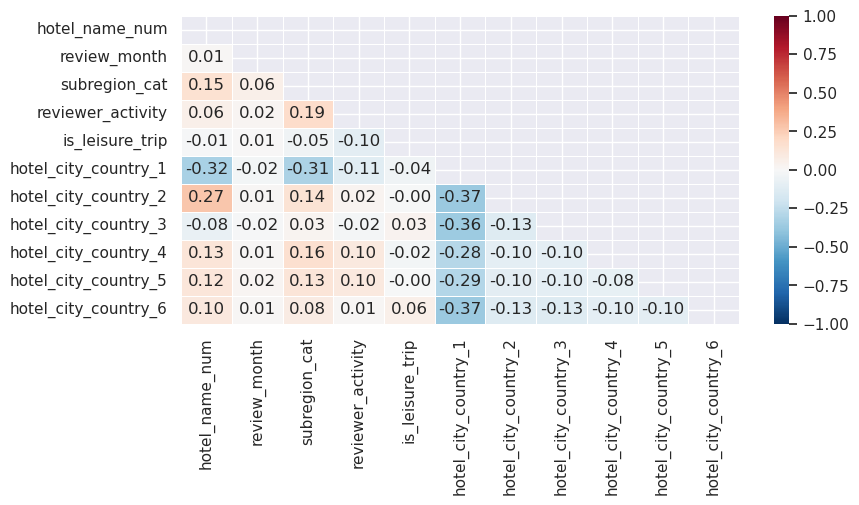

In [62]:
corr_matrix = np.tril(X_train[categorical_vars].corr(method='spearman'))
corr_matrix[corr_matrix == 0] = np.NaN
np.fill_diagonal(corr_matrix, np.NaN)

fig, ax = plt.subplots(figsize=(9, 4))
sns.heatmap(
    data=corr_matrix, 
    vmin=-1, 
    vmax=1,
    fmt='.2f', 
    cmap="RdBu_r", 
    linewidths=0.5, 
    annot=True, 
    xticklabels=X_train[categorical_vars].columns,
    yticklabels=X_train[categorical_vars].columns,
    robust=True,
    ax=ax);

В соответствии с регрессионным анализом наибольшую предиктивную силу имеют признаки, которые фиксируют тональность коментария резендента, а так же средний бал, полученный отелем. Проверка значений коэффициентов корреляции между независимыми переменными показывает, что высокая корреляции между большинством признаком отсутвует. Исключением является общее и дополнительное количтво оценок, полученных отелем. Вероятно, вторая переменная является производной (определенная доля от общего числа оценок).

На данном этапе, все имеющиеся переменные будут участвовать в создании модели.

# 4. Model specification

Разделение датасета на тренировочную и тестовую часть

In [63]:
train_data = df_model[train_mask].drop(columns=['is_train'])
test_data = df_model[~train_mask].drop(columns=['is_train', 'reviewer_score'])

X = train_data.drop(columns=['reviewer_score'])
y = train_data['reviewer_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123456)

In [64]:
pd.DataFrame({
    'Train data':  train_data.shape,
    'y': (y.shape[0], 1),
    'X': X.shape,
    'X (train)': X_train.shape,
    'X (test)': X_test.shape,
    'Test data': test_data.shape
    },
    index=['Rows', 'Variables']
)

,Train data,y,X,X (train),X (test),Test data
Rows,386496,386496,386496,347846,38650,128935
Variables,22,1,21,21,21,21


# 5. Model evaluation

In [65]:
# Add light pruning to the decision trees
model = RandomForestRegressor(
    n_estimators=100,
    criterion='friedman_mse',
    min_samples_leaf=10,
    max_samples=0.8,
    verbose=0,
    n_jobs=-1,
    random_state=123456
)

In [66]:
model.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', max_samples=0.8,
                      min_samples_leaf=10, n_jobs=-1, random_state=123456)

In [67]:
y_pred = model.predict(X_test)

In [68]:
print('MAPE:', np.round(mean_absolute_percentage_error(y_test, y_pred), 4))

MAPE: 0.1252


In [69]:
(pd.DataFrame.from_dict(
    model.get_params(), orient='index')
    .rename(columns={0: 'param_value'})
)

,param_value
bootstrap,True
ccp_alpha,0.00
criterion,friedman_mse
max_depth,None
max_features,1.00
max_leaf_nodes,None
max_samples,0.80
min_impurity_decrease,0.00
min_samples_leaf,10
min_samples_split,2


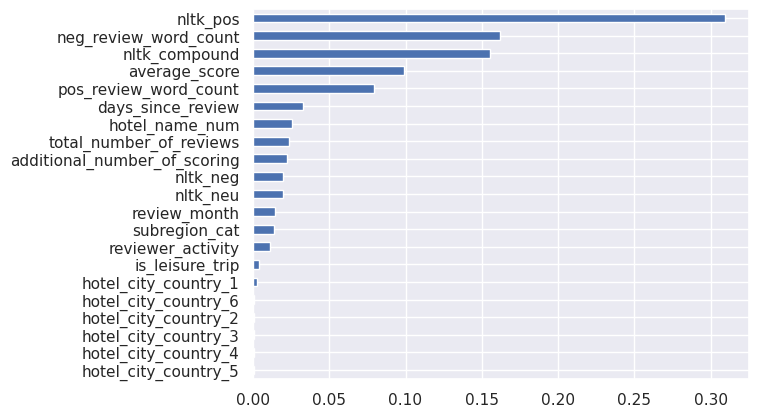

In [70]:
feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
feat_importance.plot(kind='barh');

In [71]:
predict_submission = model.predict(test_data)

In [72]:
df_submit['reviewer_score'] = predict_submission

In [73]:
df_submit.head()

,reviewer_score,id
0,8.66,488440
1,7.35,274649
2,8.35,374688
3,9.73,404352
4,9.62,451596


In [74]:
df_submit.to_csv('/kaggle/working/submission.csv', index=False)

In [75]:
executionTime = time.time() - start_time
print(f'Execution time: {executionTime:.0f} seconds')

Execution time: 529 seconds
